In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!gdown https://drive.google.com/drive/folders/19JWGJib5Y3PixVbsAf-EpYZZkkFvU6DC?usp=sharing

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://drive.google.com/drive/folders/19JWGJib5Y3PixVbsAf-EpYZZkkFvU6DC?usp=sharing
To: /content/19JWGJib5Y3PixVbsAf-EpYZZkkFvU6DC?usp=sharing
1.64kB [00:00, 3.26MB/s]


In [5]:
import os
#os.chdir("/content/drive/My Drive/Colab Notebooks/Comp432Project/Dataset1/ColorectalCancer_")#100
os.chdir("/content/drive/My Drive/Colab Notebooks/500 Data/Colorectal Cancer") #500

In [6]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim
from torchvision import datasets, transforms

import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report


#print(torch.cuda.is_available())

#torch.cuda.empty_cache()

In [7]:
def get_data():
    #data_dir = '/content/drive/My Drive/Colab Notebooks/Comp432Project/Dataset1/ColorectalCancer_' #100
    data_dir = '/content/drive/My Drive/Colab Notebooks/500 Data/Colorectal Cancer' #500
    transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((128,128))])
    data_set = datasets.ImageFolder(root=data_dir, transform=transform)
    print(data_set.classes)

    n = len(data_set)  # total number of examples
    n_test = int(0.20 * n)  # take ~20% for test
    for x in range(0, 9):  # rounding it to be divisible by 4
        n_test += 1
        if n_test % 4 == 0:
            break
    train_set, test_set = torch.utils.data.random_split(data_set, [n - n_test, n_test])

    train = DataLoader(train_set, batch_size=32, shuffle=True)
    test = DataLoader(test_set, batch_size= 10, shuffle=False)


    return train, test


In [8]:

# Defining the Model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer (conv1)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer (conv2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (if needed)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)

        return out


#
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



In [9]:
# Getting the data
train, test= get_data()
# Instanciating the ResNet18 Class created earlier and Assigning it as our model
model = ResNet18(3)

# The loss function
criterion = nn.CrossEntropyLoss()
#
optimizer = optim.Adam(model.parameters(), lr=0.001)
# momentum=0.9

# Using Cuda cores for the training
#model=model.cuda()


['MUS', 'NORM', 'STR']


In [ ]:
# Training
num_epoch=10
num_epoch_saved=0
lr=0.01
test_size=0


train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

running_train_losses = []
running_test_losses = []

#For Saving the model
#'/content/drive/My Drive/Colab Notebooks/Saved models/Latest save'
model_name_to_save = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Saved models/Latest save/{model_name_to_save}"


print("train")
for epoch in range(num_epoch):
    model.train()
    loss_train= 0.0
    correct = 0
    total = 0
    test_size=0

    if epoch>=1:
      state_dict = torch.load(save_dir)
      model.load_state_dict(state_dict)


    for inputs, labels in train:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss_train = criterion(outputs, labels)
      loss_train.backward()
      optimizer.step()

      #Loss by input Train
      loss_by_input=loss_train.item()
      loss_train += loss_train.item()
      print(f"Epoch {epoch+1}/{num_epoch}, Loss: {loss_by_input}")

      #Accuracy
      total += labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()


    # Checking if the loss has improved this epoch. If so it will save that model,
    # otherwise it will just reload the previous  model and continue from there.
    loss_by_epoch=loss_train / len(train)
    print("This epoch:")
    print(loss_by_epoch.detach().numpy())
    if ((epoch <= 0) or (loss_by_epoch.detach().numpy() <= train_losses[-1])):
      num_epoch_saved=num_epoch_saved+1
      #Save model
      torch.save(model.state_dict(), save_dir)
      print('saved')
      #Loss by batch Train
      train_losses.append(loss_by_epoch.detach().numpy())

      running_train_losses.append(loss_by_input) #New

      #Accuracy by batch Train
      accuracy = correct / total
      train_accuracy.append(accuracy)
      print(f"Epoch {epoch+1}/{num_epoch}, Accuracy: {accuracy}")

      #Test
      model.eval()
      loss_test = 0.0
      correct2 = 0
      total2 = 0

      with torch.no_grad():
        for inputs, labels in test:
          outputs = model(inputs)

          test_size+=1

          #Loss Test
          loss_test = criterion(outputs, labels)
          loss_by_input_test=loss_test.item()#New
          loss_test += loss_test.item()

          running_test_losses.append(loss_by_input_test)#New

          #Accuracy Test
          total2 += labels.size(0)
          _, predicted2 = torch.max(outputs.data, 1)
          correct2 += (predicted2 == labels).sum().item()

        loss_by_epoch2=loss_test / len(test)
        test_losses.append(loss_by_epoch2.detach().numpy())

        accuracy2 = correct2 / total2
        test_accuracy.append(accuracy2)
        print(test_size)

      print("Test end")

print(num_epoch)
print(len(train_losses))
print(len(test_losses))


#Save model
torch.save(model.state_dict(), save_dir)
print('saved')

#del model
#torch.cuda.empty_cache()

# Plot Loss Train
plt.plot(range(1, num_epoch_saved+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss By Epoch')
plt.legend()
plt.show()


# Plot Accuracy Train
plt.plot(range(1, num_epoch_saved+1), train_accuracy , label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy By Epoch')
plt.legend()
plt.show()

# Plot Loss Test
plt.plot(range(1, num_epoch_saved+1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')
plt.title('Testing Loss By Epoch')
plt.legend()
plt.show()

# Plot Accuracy Test
plt.plot(range(1, num_epoch_saved+1), test_accuracy , label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy By Epoch')
plt.legend()
plt.show()


#By input
plt.plot(range(1, len(running_train_losses)+1), running_train_losses, label='Training Loss by Inputs')
plt.xlabel('Inputs')
plt.ylabel('Training Loss')
plt.title('Training Loss By Inputs')
plt.legend()
plt.show()

plt.plot(range(1, len(running_test_losses)+1), running_test_losses, label='Testing Loss by Inputs')
plt.xlabel('Inputs')
plt.ylabel('Testing Loss')
plt.title('Testing Loss By Inputs')
plt.legend()
plt.show()


train


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/10, Loss: 1.0976892709732056
Epoch 1/10, Loss: 2.6914896965026855
Epoch 1/10, Loss: 2.0665268898010254
Epoch 1/10, Loss: 1.8049589395523071
Epoch 1/10, Loss: 3.189069986343384
Epoch 1/10, Loss: 1.0248634815216064
Epoch 1/10, Loss: 0.9002000093460083
Epoch 1/10, Loss: 0.5329868197441101
This epoch:
0.1332467
saved
Epoch 1/10, Accuracy: 0.4322033898305085
7
Test end
Epoch 2/10, Loss: 0.7774129509925842
Epoch 2/10, Loss: 0.746524453163147
Epoch 2/10, Loss: 0.9423298835754395
Epoch 2/10, Loss: 0.7832517027854919
Epoch 2/10, Loss: 1.0640789270401
Epoch 2/10, Loss: 0.6023486256599426
Epoch 2/10, Loss: 0.5040721893310547
Epoch 2/10, Loss: 1.5089654922485352
This epoch:
0.37724137
Epoch 3/10, Loss: 0.7653570175170898
Epoch 3/10, Loss: 0.7280060052871704
Epoch 3/10, Loss: 0.5629312992095947
Epoch 3/10, Loss: 0.7112966775894165
Epoch 3/10, Loss: 0.4614943861961365
Epoch 3/10, Loss: 0.46634212136268616
Epoch 3/10, Loss: 0.8399976491928101
Epoch 3/10, Loss: 0.6065542101860046
This epoch:
0

KeyboardInterrupt: ignored

Test


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


end


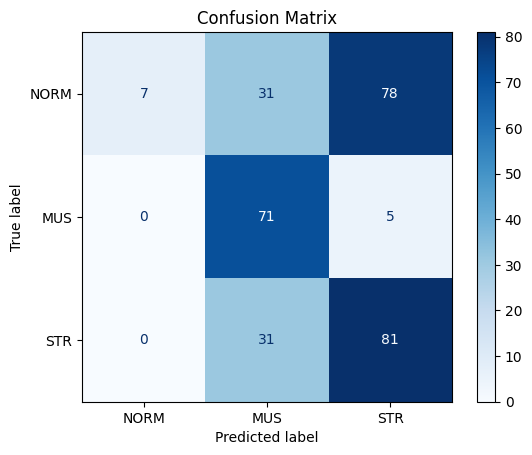

              precision    recall  f1-score   support

        NORM       1.00      0.06      0.11       116
         MUS       0.53      0.93      0.68        76
         STR       0.49      0.72      0.59       112

    accuracy                           0.52       304
   macro avg       0.68      0.57      0.46       304
weighted avg       0.70      0.52      0.43       304



In [12]:
#Test
#Load model
model_name_to_load = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Saved models/Latest save/{model_name_to_load}"

state_dict = torch.load(save_dir)
model.load_state_dict(state_dict)

print('Test')
labels_array = []
predictions = []

model.eval()

with torch.no_grad():
  for inputs, labels in test:
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    labels_array.extend(labels.cpu().numpy())
    predictions.extend(predicted.cpu().numpy())

    #labels.extend(labels.cuda().numpy())
    #predictions.extend(predicted.cuda().numpy())
print("end")

# Confusion matrix
c_matrix = confusion_matrix(labels_array, predictions, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(c_matrix, display_labels=['NORM', 'MUS', 'STR'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

#Classification report
print("On Testing Data")
print(classification_report(labels_array, predictions, target_names=['NORM', 'MUS', 'STR']))




In [13]:
#Classification Report on training data
#Load model
model_name_to_load = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Saved models/Latest save/{model_name_to_load}"

state_dict = torch.load(save_dir)
model.load_state_dict(state_dict)

with torch.no_grad():
  for inputs, labels in train:
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    labels_array.extend(labels.cpu().numpy())
    predictions.extend(predicted.cpu().numpy())

    #labels.extend(labels.cuda().numpy())
    #predictions.extend(predicted.cuda().numpy())
print("end")
#Classification report
print("On Training Data")
print(classification_report(labels_array, predictions, target_names=['NORM', 'MUS', 'STR']))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


KeyboardInterrupt: ignored